In [1]:
from torchvision.transforms.v2.functional import grayscale_to_rgb
%load_ext autoreload

In [2]:
%autoreload 2
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from datasets import load_dataset
from dataset import get_elements_from_indexes, TRAIN_DATASET, LABELS
from segmentation.k_means import kmeans, KmeansFlags, KmeansTermCrit, KmeansTermOpt
import numpy as np
from common.histogram import img2hist, plot_hist
from matplotlib.widgets import EllipseSelector, RectangleSelector
import cv2
from improving.filtering import conv2d

In [3]:
%matplotlib notebook
plt.ioff()

In [5]:
def draw_grayscale_image(image, ax, cmap='gray'):
    ax.imshow(image, cmap=cmap, vmin=0, vmax=255)
    ax.axis('off')

In [6]:
dataset_dic = load_dataset(**TRAIN_DATASET)
print(dataset_dic)

Dataset({
    features: ['image', 'label'],
    num_rows: 5120
})


In [7]:
random_index = np.random.randint(len(dataset_dic))
element = get_elements_from_indexes(dataset_dic, random_index)[0]
image = element[0]
label = element[1]

In [11]:
if 'fig_hist' in globals():
    plt.close('Figure & Histogram')
fig_hist, axs_hist = plt.subplots(1, 2, figsize=(10, 4), num='Figure & Histogram')
draw_grayscale_image(image, axs_hist[0])
axs_hist[0].set_title(f"Training Image {random_index}:\n{LABELS[label]}", fontsize=10)
image_hist = img2hist(image)
plot_hist(image_hist, **{'figure': fig_hist, 'ax': axs_hist[1], 
                         'color': 'b', 'show': False, 'title': None})
axs_hist[1].set_title(f"Histogram", fontsize=10)
fig_hist.tight_layout()
fig_hist.show()

<IPython.core.display.Javascript object>

In [12]:
image_selection = None

def select_callback(eclick, erelease):
    global image_selection
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    if x1 is None or y1 is None or x2 is None or y2 is None:
        return
    image_selection = image[int(y1):int(y2), int(x1):int(x2)]
    image_selection_hist = img2hist(image_selection)
    axs_selection[1].clear()
    plot_hist(image_selection_hist, **{'title': 'Histograma del Recuadro de la Imagen',
                                  'xlabel': 'Valor del pixel',
                                  'ylabel': 'Frecuencia',
                                  'figure': fig_selection,
                                  'ax': axs_selection[1],
                                  'show': False})
    fig_selection.canvas.draw_idle()

if 'fig_selection' in globals():
    plt.close("Recuadro de la Imagen e Histograma")
fig_selection = plt.figure(layout='constrained', num="Recuadro de la Imagen e Histograma", figsize=(10, 5))
axs_selection = fig_selection.subplots(1, 2)
draw_grayscale_image(image, axs_selection[0])
axs_selection[0].set_title('Seleccionar Recuadro de la Imagen')
axs_selection[1].set_title('Histograma del Recuadro de la Imagen')
axs_selection[1].set_xlabel('Valor del pixel')
axs_selection[1].set_ylabel('Frecuencia')
selector = RectangleSelector(axs_selection[0], select_callback,
                             useblit=True,
                             button=[1, 3],  # disable middle button
                             minspanx=5, minspany=5,
                             spancoords='pixels',
                             interactive=True)
selector.set_active(True)
fig_selection.show()

<IPython.core.display.Javascript object>

In [14]:
print(np.std(image_selection))

2.2107690969434146


In [15]:
# @title Filtro Gausiano {"run":"auto"}
epsilon = 0.1 # @param {"type":"slider","min":0.001,"max":0.1,"step":0.001}
# La imagen presenta ruido. Lo filtramos con un kernel gaussiano
sigma = 3
gaussianDim = int(np.ceil(np.sqrt(-2 * sigma ** 2 * np.log(epsilon * sigma * np.sqrt(2 * np.pi)))))
gaussianKernel1D = cv2.getGaussianKernel(gaussianDim, sigma)
gaussianKernel = np.outer(gaussianKernel1D, gaussianKernel1D)
filtered_image = conv2d(image, gaussianKernel)

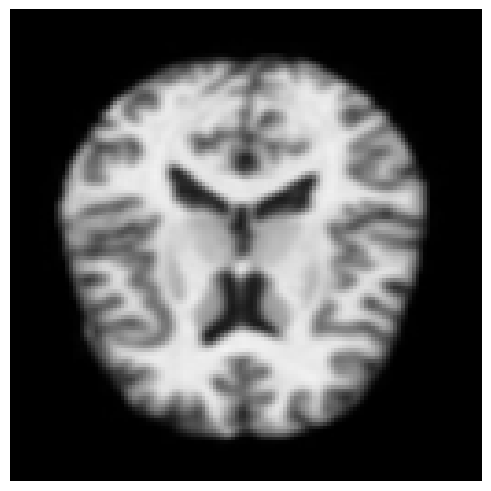

In [16]:
if 'filtered_image_figure' in globals():
    plt.close('Imagen filtrada')
filtered_image_figure = plt.figure(num='Imagen filtrada', layout='constrained')
filtered_image_ax = filtered_image_figure.subplots(1,1)
draw_grayscale_image(filtered_image, filtered_image_ax)
filtered_image_figure

In [17]:
compactness, labels, centers = kmeans(filtered_image.flatten(), 3, criteria=KmeansTermCrit(KmeansTermOpt.BOTH, 20, 0.5), flags=KmeansFlags.KMEANS_PP_CENTERS, attempts=5)
centers = centers.astype(np.uint8)
segmented_kmeans = centers[labels].reshape(image.shape)
sorted_centers = sorted(centers)
background_idx = np.argmax(centers == sorted_centers[0])
grey_matter_idx = np.argmax(centers == sorted_centers[1])
white_matter_idx = np.argmax(centers == sorted_centers[2])
segmented_white_matter = np.where(segmented_kmeans == centers[white_matter_idx], 1, 0)
segmented_grey_matter = np.where(segmented_kmeans == centers[grey_matter_idx], 1, 0)
segmented_background = np.where(segmented_kmeans == centers[background_idx], 1, 0)

In [18]:
if 'fig_kmeans' in globals():
    plt.close('Kmeans results')
fig_kmeans, axs_kmeans = plt.subplots(2, 2, num='Kmeans results')
draw_grayscale_image(segmented_kmeans, axs_kmeans[0][0])
draw_grayscale_image(segmented_white_matter * 255, axs_kmeans[0][1])
draw_grayscale_image(segmented_grey_matter * 255, axs_kmeans[1][0])
draw_grayscale_image(segmented_background * 255, axs_kmeans[1][1])
fig_kmeans.tight_layout()
fig_kmeans.show()

<IPython.core.display.Javascript object>